In [1]:
from scipy.integrate import odeint
from scipy.stats import lognorm
import numpy as np
from ode_api import *
from ode_funcs import *
import matplotlib.pyplot as plt
import scipy
import pymc3 as pm

THEANO_FLAGS = 'exception_verbosity=high'

WARNING (theano.configdefaults): install mkl with `conda install mkl-service`: No module named 'mkl'


# Test 1: Scalar ODE with 1 parameter

$$ y' = exp(-t) - \alpha y \quad y(0) = 0 $$

In [2]:
#Specify how many stats, initial values, and ode parameters there are
n_states = 1
n_ivs = 1
n_odeparams = 1

#Times to evaluate the solution
times = np.arange(0.5,8,1)

#Instantiate the ODEModel
model_1 = ODEModel(odefunc = test_ode_func_1, 
                   y0 = 0,
                   t0 = 0,
                    times = times,
                    n_states = n_states,
                    n_ivs = n_ivs,
                    n_odeparams = n_odeparams)

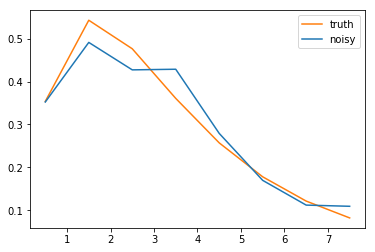

In [3]:
#Simulate the data and create data to learn from
sims, sens = model_1.simulate([0.4,0])
sims = sims.ravel()


Y = lognorm.rvs(s = 0.1, scale = sims)
plt.plot(times,sims, color = 'C1', label = 'truth')
plt.plot(times, Y, label = 'noisy')
plt.legend()

In [4]:
# Now instantiate the theano custom ODE op
my_ODEop = ODEop(model_1)

In [51]:
# The probabilistic model
with pm.Model() as first_model:

    # Priors for unknown model parameters
    alpha = pm.Lognormal('alpha',1,1)
    
    sigma = pm.Lognormal('sigma',1,1)

    # Forward model
    all_params = pm.math.stack([alpha, 0],axis=0)
    ode_sol = my_ODEop(all_params)
    forward = ode_sol.reshape(Y.shape)

    # Likelihood 
    Y_obs = pm.Lognormal('Y_obs', mu=np.log(forward), sd=sigma, observed=Y)
    
    trace = pm.sample(2000, tune=1000, init='adapt_diag')

pm.traceplot(trace)

plt.show()

Auto-assigning NUTS sampler...
Initializing NUTS using adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sigma, alpha]
Sampling 2 chains:   0%|          | 15/6000 [00:01<11:00,  9.06draws/s]/Users/demetri/miniconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)

Bad initial energy, check any log probabilities that are inf or -inf, nan or very small:
Series([], )


ParallelSamplingError: Bad initial energy

In [52]:
for i in range(10):
    print(first_model.test_point)

{'alpha_log__': array(0.99999997), 'sigma_log__': array(0.99999997)}
{'alpha_log__': array(0.99999997), 'sigma_log__': array(0.99999997)}
{'alpha_log__': array(0.99999997), 'sigma_log__': array(0.99999997)}
{'alpha_log__': array(0.99999997), 'sigma_log__': array(0.99999997)}
{'alpha_log__': array(0.99999997), 'sigma_log__': array(0.99999997)}
{'alpha_log__': array(0.99999997), 'sigma_log__': array(0.99999997)}
{'alpha_log__': array(0.99999997), 'sigma_log__': array(0.99999997)}
{'alpha_log__': array(0.99999997), 'sigma_log__': array(0.99999997)}
{'alpha_log__': array(0.99999997), 'sigma_log__': array(0.99999997)}
{'alpha_log__': array(0.99999997), 'sigma_log__': array(0.99999997)}


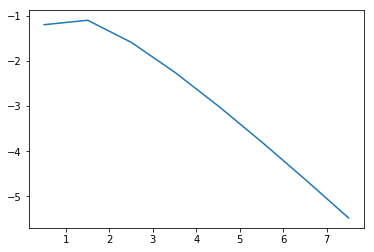

In [59]:
sol, sens = model_1.cached_solver([0.999,0])

plt.plot(times, np.log(sol))